## Current SOTA: 78.5% -> NumPreg, PlasmaGlucose, BodyMassIndex, Pedigree

#### Pre-processing and Visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from itertools import combinations
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [2]:
random.seed(21)
np.random.seed(21)

In [3]:
data = pd.read_csv('./data.csv', encoding = 'utf-8')

In [4]:
data

,NumPreg,PlasmaGlucose,DiastolicBP,TricepSkin,BodyMassIndex,Pedigree,Age,Diabetic
0,5,86,68,28,30.2,0.364,24,No
1,7,195,70,33,25.1,0.163,55,Yes
2,5,77,82,41,35.8,0.156,35,No
3,0,165,76,43,47.9,0.259,26,No
4,0,107,60,25,26.4,0.133,23,No
5,5,97,76,27,35.6,0.378,52,Yes
6,3,83,58,31,34.3,0.336,25,No
7,1,193,50,16,25.9,0.655,24,No
8,3,142,80,15,32.4,0.200,63,No
9,2,128,78,37,43.3,1.224,31,Yes


In [5]:
metrics = ['NumPreg', 'PlasmaGlucose', 'DiastolicBP', 'TricepSkin', 'BodyMassIndex', 'Pedigree', 'Age']
data[metrics]=(data[metrics]-data[metrics].mean())/data[metrics].std()

#### Exploratory Analysis

In [6]:
data['Diabetic'] = data['Diabetic'].apply(lambda x: 0 if x == 'No' else 1)

In [7]:
data[metrics] = data[metrics].apply(lambda column: (column - column.mean()) / column.std(), axis = 0)

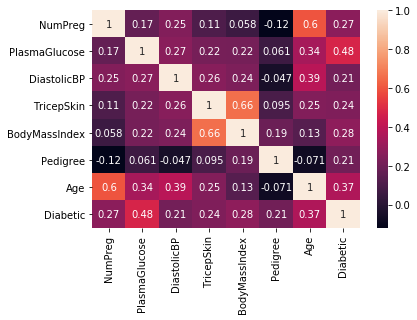

In [8]:
correlation_heatmap = data.corr()
sns.heatmap(correlation_heatmap, annot = True, xticklabels = correlation_heatmap.columns, yticklabels = correlation_heatmap.columns)

In [9]:
def sublists(input_list):
    subs = []

    for i in range(0, len(input_list) + 1):
        temp = [list(x) for x in combinations(input_list, i)]

        if len(temp) > 0:
            subs.extend(temp)
    return subs

In [10]:
def grapher(coeff, labels):
    features = pd.DataFrame()
    features['Features'] = labels
    features['importance'] = coeff
    features.sort_values(by = ['importance'], ascending = True, inplace = True)
    features['positive'] = features['importance'] > 0
    features.set_index('Features', inplace = True)
    features.importance.plot(kind = 'barh', figsize = (11, 6), color = features.positive.map({True: 'blue', False: 'red'}))
    plt.xlabel('Importance')

In [11]:
def tester(X, Y, iterations = 1, graph = False):
    kf = KFold(n_splits = 10, shuffle = True)
    scores = []
    mean_scores = []

    for i in range(iterations):
        for train_index, test_index in kf.split(X):
            train_length = len(train_index)
            valid_index = train_index[:train_length//5]
            train_index = train_index[train_length//5:]
            
            X_train, X_test = X.iloc[train_index].drop(['index'], axis = 1), X.iloc[test_index].drop(['index'], axis = 1)
            Y_train, Y_test = Y.iloc[train_index].drop(['index'], axis = 1), Y.iloc[test_index].drop(['index'], axis = 1)    
            clf = linear_model.LogisticRegression(solver = 'newton-cg', penalty = 'l2', multi_class = 'ovr', max_iter = 200).fit(X_train, Y_train.values.ravel())
            if graph:
                grapher(list(clf.coef_[0]), list(X_train.columns))
                graph = False
            scores.append(clf.score(X_test, Y_test))

        mean_scores.append(np.mean(scores))
    
    return np.mean(mean_scores)

In [12]:
def tester_with_threshold(X, Y):
    kf = KFold(n_splits=5, shuffle=True)
    scores = []
    mean_scores = []
    best_thresholds = []
    mean_thresholds = []
    threshold_choises = np.arange(0.3,1,0.05)
    
    scores = []
    best_thresholds = []
    for train_index, test_index in kf.split(X):
        train_length = len(train_index)
        valid_index = train_index[:train_length//5]
        train_index = train_index[train_length//5:]
        if isinstance(X, np.ndarray):
            X_train, X_valid, X_test = X[train_index], X[valid_index], X[test_index]
            Y_train, Y_valid, Y_test = Y[train_index], Y[valid_index], Y[test_index]
            clf = linear_model.LogisticRegression(solver = 'lbfgs', penalty = 'l2', max_iter = 200).fit(X_train, Y_train.ravel())

        elif isinstance(X, pd.DataFrame):
            X_train, X_valid, X_test = X.iloc[train_index].drop(['index'], axis = 1), X.iloc[valid_index].drop(['index'], axis = 1), X.iloc[test_index].drop(['index'], axis = 1)
            Y_train, Y_valid, Y_test = Y.iloc[train_index].drop(['index'], axis = 1), Y.iloc[valid_index].drop(['index'], axis = 1), Y.iloc[test_index].drop(['index'], axis = 1)    
            clf = linear_model.LogisticRegression(solver = 'lbfgs', penalty = 'l2', max_iter = 200).fit(X_train, Y_train.values.ravel())
            Y_valid = Y_valid.values
            Y_test = Y_test.values
        else:
            raise TypeError("X")
        valid_prob = clf.predict_proba(X_valid)[:,1] # probability of 'Yes' class
        best_thr = 0.0
        best_ac = 0.0
        for threshold in threshold_choises:
            ac = accuracy_score(Y_valid.ravel()==1, valid_prob >= threshold)
            if ac > best_ac:
                best_ac = ac
                best_thr = threshold
        best_thresholds.append(best_thr)
        scores.append(accuracy_score(Y_test.ravel()==1, clf.predict_proba(X_test)[:,1] >= best_thr))


    mean_scores.append(np.mean(scores))
    mean_thresholds.append(np.mean(best_thresholds))
    
    return np.mean(mean_scores), np.mean(mean_thresholds)

['NumPreg', 'PlasmaGlucose', 'DiastolicBP', 'TricepSkin', 'BodyMassIndex', 'Pedigree', 'Age']
0.745


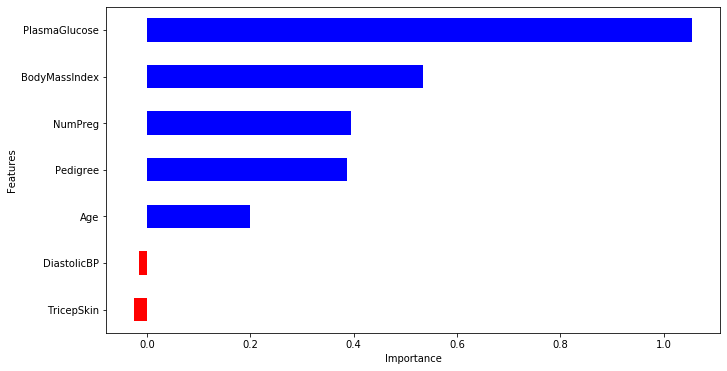

In [13]:
X = data[metrics].reset_index()
Y = data['Diabetic'].reset_index()
score = tester(X, Y, 1, True)
print(metrics)
print(score)

In [14]:
power_metrics = sublists(metrics)
max_score = -1

for metric_list in power_metrics:
    if metric_list == []:
        continue
    X = data[metric_list].reset_index()
    Y = data['Diabetic'].reset_index()
    score = tester(X, Y)
    if score > max_score:
        max_score = score
        print(metric_list)
        print(max_score)

['NumPreg']
0.6850000000000002
['PlasmaGlucose']
0.755
['PlasmaGlucose', 'DiastolicBP', 'Pedigree']
0.77
['PlasmaGlucose', 'BodyMassIndex', 'Pedigree']
0.78


In [15]:
power_metrics = sublists(metrics)
max_score = -1

for metric_list in power_metrics:
    if metric_list == []:
        continue
    X = data[metric_list].reset_index()
    Y = data['Diabetic'].reset_index()
    score, threshold = tester_with_threshold(X, Y)
    if score > max_score:
        max_score = score
        print(metric_list)
        print(max_score, threshold)

['NumPreg']
0.71 0.41999999999999993
['NumPreg', 'PlasmaGlucose']
0.7150000000000001 0.6299999999999999
['PlasmaGlucose', 'TricepSkin']
0.7300000000000001 0.43999999999999995
['PlasmaGlucose', 'BodyMassIndex']
0.7849999999999999 0.45999999999999996
['NumPreg', 'PlasmaGlucose', 'Pedigree']
0.7899999999999999 0.5399999999999998


In [16]:
X = data[metrics]
Y = data['Diabetic'].reset_index()

pca = PCA(n_components=7, whiten=True)
X = pd.DataFrame(pca.fit_transform(X), index = None).reset_index()

for num_components in range(1, 8):
    X_components = pd.DataFrame(X.values[:, 1:num_components+1], index=None).reset_index()
    score = tester(X_components, Y)
    print('No. of components: {}, Score: {}'.format(num_components, score))

No. of components: 1, Score: 0.725
No. of components: 2, Score: 0.7300000000000001
No. of components: 3, Score: 0.79
No. of components: 4, Score: 0.7649999999999999
No. of components: 5, Score: 0.7550000000000001
No. of components: 6, Score: 0.76
No. of components: 7, Score: 0.75
